`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print(OPENAI_API_KEY[:2])

UPSTAGE_API_KEY = os.getenv("UPSTAGE_API_KEY")
print(UPSTAGE_API_KEY[30:])

sk
Fy


#### MessageGraph 역할
* MessageGraph는 **채팅 및 대화형 애플리케이션**을 구축하는 데 특화된 그래프 클래스입니다. 
    * 일반적인 StateGraph가 딕셔너리 기반의 상태를 관리하는 반면, MessageGraph는 대화의 흐름을 나타내는 **메시지 목록(list[messages])**을 핵심 상태로 사용합니다. 
    * 이를 통해 사용자와 AI 간의 상호작용을 자연스럽게 모델링하고 관리할 수 있습니다.

* MessageGraph는 다음과 같은 주요 기능을 제공합니다.
    * 메시지 기반 상태 관리: 상태를 messages라는 키를 가진 리스트로 자동 설정하여, 사용자와 AI의 대화 기록을 손쉽게 추적할 수 있습니다.
    * 자동 병합: 각 노드에서 새로운 메시지 목록을 반환하면, MessageGraph는 이를 기존 메시지 목록에 자동으로 추가(append)합니다. 
        * 이는 StateGraph에서 Annotated와 add를 사용해 수동으로 구현해야 했던 기능을 기본적으로 제공합니다.
    * 대화 중심 흐름: 대화형 에이전트의 작동 방식을 직관적으로 표현합니다. 한 노드에서 사용자 메시지를 처리하고, 다른 노드에서 AI 응답을 생성하는 등 대화의 각 단계를 명확하게 구분할 수 있습니다.

`(1) Messages State 정의`
- 이전 대화 기록을 그래프 상태에 메시지 목록으로 저장하는 것이 유용
- 그래프 상태에 Message 객체 목록을 저장하는 키(채널)를 추가하고, 이 키에 리듀서 함수를 추가 
- 리듀서 함수 선택:
    - operator.add를 사용하면: 새 메시지를 기존 목록에 단순히 추가
    - add_messages 함수를 사용하면:
        - 새 메시지는 기존 목록에 추가
        - 기존 메시지 업데이트도 올바르게 처리 (메시지 ID를 추적)
```python
class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]        
```    

`(2) RAG Chain 구성`
- 메뉴 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)
- LangChain Runnable로 구현

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from langchain_community.vectorstores import FAISS
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

from langchain_openai import ChatOpenAI
from langchain_upstage import UpstageEmbeddings
from langchain_upstage import ChatUpstage

# LangGraph MessagesState라는 미리 만들어진 상태를 사용
from langgraph.graph import MessagesState
from langchain_core.documents import Document
from langgraph.graph import StateGraph, START, END

from textwrap import dedent
from typing import List, Literal, Tuple
from pydantic import BaseModel, Field

import gradio as gr

from pprint import pprint




c:\Users\user\AppData\Local\pypoetry\Cache\virtualenvs\mylangchain-app-SBe-Yh6W-py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

embeddings_model = UpstageEmbeddings(model="solar-embedding-1-large")

# menu db 벡터 저장소 로드
menu_db = FAISS.load_local(
    "../db/menu_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# LLM 모델 
#llm = ChatOpenAI(model="gpt-4o-mini")
llm = ChatUpstage(
        model="solar-pro",
        base_url="https://api.upstage.ai/v1",
        temperature=0.5
)
print(llm.model_name)

# RAG 체인 구성
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

system = """
You are a helpful assistant. Use the following context to answer the user's question:

[Context]
{context}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

# 검색기 정의
retriever = menu_db.as_retriever(
    search_kwargs={"k": 6}
)

query = "채식주의자를 위한 메뉴를 추천해주세요."
retrieved_docs = retriever.invoke(query)

# 검색된 문서 출력
for doc in retrieved_docs:
    print(vars(doc))

In [ ]:

# RAG 체인 구성
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# RAG 체인 실행
query = "채식주의자를 위한 메뉴를 추천해주세요."
response = rag_chain.invoke(query)

# 답변 출력
print(response)

`(3) 노드(Node)`

In [5]:

class GraphState(MessagesState):
    # messages key는 기본적으로 제공 - 다른 키를 추가하고 싶을 경우 아래 주석과 같이 적용 가능 
    documents: List[Document]
    grade: float
    num_generation: int
    
# 이 함수는 사용자의 질문을 받아 문서를 검색하고 답변을 생성합니다.
def retrieve_and_respond(state: GraphState):
    print("==>1. retrieve_and_respond")
    # 'messages' 리스트의 가장 마지막 메시지를 가져옵니다.
    # state['messages'][-1]은 사용자의 마지막 질문을 가져옵니다.
    last_human_message = state['messages'][-1]
    
    # HumanMessage 객체에서 실제 질문 내용(텍스트)을 가져옵니다.
    query = last_human_message.content
    
    # retriever를 사용하여 쿼리와 관련된 문서를 벡터DB에서 검색합니다.
    retrieved_docs = retriever.invoke(query)
    
    # RAG 체인(rag_chain)을 사용하여 쿼리에 대한 최종 답변을 생성합니다.
    # 이 체인은 검색된 문서를 LLM에 전달하여 답변의 근거로 사용합니다.
    response = rag_chain.invoke(query)
    
    # 검색된 문서와 AI의 응답을 GraphState에 저장하여 반환합니다.
    # 'messages' 필드에는 새로운 AI 응답(AIMessage)이 추가됩니다.
    # 'documents' 필드에는 검색된 문서 목록이 저장됩니다.
    return {
        "messages": [AIMessage(content=response)],
        "documents": retrieved_docs
    }

#### Pydantic 모델 정의: 
* GradeResponse는 LLM의 출력 형식을 **점수(score)**와 **설명(explanation)**을 포함하는 구조로 강제합니다. 
* 이 모델을 통해 LLM은 정해진 규칙을 따르는 정형화된 JSON 응답을 생성합니다.

#### 답변 평가 함수: grade_answer 함수
* 정보 추출: state 객체에서 사용자의 **질문(-2)**과 AI의 답변(-1), 그리고 답변의 근거가 된 **문서(documents)**를 가져옵니다.
* 프롬프트 생성: LLM에게 평가 전문가 역할을 부여하는 시스템 메시지와 평가에 필요한 모든 정보를 담은 인간 메시지를 포함한 프롬프트를 만듭니다.
* 평가 체인 구성: llm.with_structured_output(schema=GradeResponse)를 사용해, LLM이 GradeResponse 모델에 맞춰 응답을 생성하도록 강제합니다.
* 평가 실행: 구성된 체인에 질문, 답변, 문서를 입력하여 실행하고, GradeResponse 객체를 얻습니다.
* 상태 업데이트: 평가 점수와 현재까지의 답변 생성 횟수를 state에 저장하여 반환합니다.

In [7]:

# Pydantic을 사용해 LLM 응답의 구조를 정의합니다.
# 이 클래스는 LLM이 반환해야 할 데이터 형식을 강제합니다.
class GradeResponse(BaseModel):
    """답변 평가 결과를 나타내는 모델입니다."""
    
    # score 필드는 0.0에서 1.0 사이의 점수를 나타냅니다.
    score: float = Field(
        ...,  # 반드시 값을 제공해야 함
        ge=0,  # 0보다 크거나 같음
        le=1,  # 1보다 작거나 같음
        description="0에서 1 사이의 점수, 1은 완벽한 답변을 의미"
    )
    
    # explanation 필드는 점수에 대한 설명을 담는 문자열입니다.
    explanation: str = Field(
        ...,
        description="주어진 점수에 대한 설명"
    )

# 답변 품질을 평가하는 함수
# 이 함수는 RAG 시스템의 핵심 단계 중 하나로, 생성된 답변을 자체적으로 평가합니다.
def grade_answer(state: GraphState):
    print("==>2. grade_answer")
    # LangGraph의 상태(state)에서 메시지 기록을 가져옵니다.
    messages = state['messages']
    pprint(messages)
    
    # 질문과 답변을 추출합니다.
    # -2는 사용자의 마지막 질문, -1은 AI의 마지막 답변을 의미합니다.
    question = messages[-2].content
    print('====>2. question ', type(question))
    print(question)

    answer = messages[-1].content
    print('====>2. answer ', type(answer))
    print(answer)
    
    # 검색된 문서 목록을 가져와 프롬프트에 사용하기 위해 포맷팅합니다.
    context = format_docs(state['documents'])
    print('====>2. context ')
    print(context)

    # LLM에게 평가 전문가 역할을 부여하는 시스템 프롬프트입니다.
    grading_system = """당신은 전문 평가자입니다. 주어진 맥락을 고려하여 질문에 대한 답변의 관련성과 정확성을 평가하세요.
    1이 완벽한 점수인 0에서 1 사이의 점수를 설명과 함께 제공하세요."""

    # LLM이 평가에 사용할 입력 프롬프트 템플릿을 정의합니다.
    grading_prompt = ChatPromptTemplate.from_messages([
        ("system", grading_system),
        ("human", "[Question]\n{question}\n\n[Context]\n{context}\n\n[Answer]\n{answer}\n\n[Grade]\n")
    ])
    
    # 프롬프트와 LLM을 연결하는 체인을 만듭니다.
    # .with_structured_output() 메서드는 LLM이 GradeResponse Pydantic 모델에 맞춰 응답하도록 강제합니다.
    grading_chain = grading_prompt | llm.with_structured_output(schema=GradeResponse)
    
    # 평가 체인을 실행하고, LLM의 정형화된 응답을 받습니다.
    grade_response = grading_chain.invoke({
        "question": question,
        "context": context,
        "answer": answer
    })

    # 답변 생성 시도 횟수를 추적합니다.
    num_generation = state.get('num_generation', 0)
    num_generation += 1
    
    print('====>2. grade_response.score ')
    print(grade_response.score)
    # 평가 점수와 갱신된 생성 횟수를 상태에 저장하여 반환합니다.
    return {"grade": grade_response.score, "num_generation": num_generation}

`(4) 엣지(Edge)`

In [8]:

# 이 함수는 RAG 에이전트가 다음 행동을 결정하는 '라우터' 역할을 합니다.
# 반환 값은 "retrieve_and_respond" 또는 "generate"로 고정됩니다.
# END 노드에 대한 별칭(alias)으로 "generate"로 사용합니다.
def should_retry(state: GraphState) -> Literal["retrieve_and_respond", "generate"]:
    print("==>3. should_retry 라우팅 함수")
    print("----GRADTING---")
    print("Grade Score 점수 : ", state["grade"])
    print("시도횟수 = ", state["num_generation"])

    # 답변 생성 시도 횟수를 확인합니다.
    # 만약 3번 이상 시도했다면, 더 이상 재시도하지 않고 최종 답변을 생성하도록 합니다.
    if state["num_generation"] > 2:
        return "generate"
    
    # 답변의 품질 점수를 확인합니다.
    # 점수가 0.7 미만이면, 현재 답변이 충분하지 않다고 판단하고
    # 문서를 다시 검색하여 답변을 재시도하도록 합니다.
    if state["grade"] < 0.7:
        return "retrieve_and_respond"
    else:
        # 점수가 0.7 이상이면, 답변이 충분히 좋다고 판단하고
        # 최종 답변을 생성하도록 합니다.
        return "generate"

`(5) 그래프(Graph) 구성`

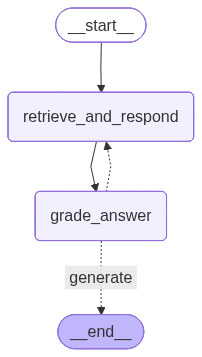

In [9]:
# StateGraph는 그래프의 상태를 관리하는 기본 클래스입니다.
# GraphState는 그래프가 공유하는 데이터의 구조를 정의한 사용자정의 클래스입니다.
builder = StateGraph(GraphState)

# --- Node 정의 ---
# 그래프에 두 개의 노드(처리 단계)를 추가합니다.
# "retrieve_and_respond": 문서를 검색하고 답변을 생성하는 노드입니다.
# "grade_answer": 생성된 답변의 품질을 평가하는 노드입니다.
builder.add_node("retrieve_and_respond", retrieve_and_respond)
builder.add_node("grade_answer", grade_answer)

# --- Edge(연결) 추가 ---
# 그래프의 시작과 끝, 그리고 노드 간의 흐름을 정의합니다.
# START에서 시작하여 "retrieve_and_respond" 노드로 이동합니다.
builder.add_edge(START, "retrieve_and_respond")

# "retrieve_and_respond" 노드에서 "grade_answer" 노드로 이동합니다.
builder.add_edge("retrieve_and_respond", "grade_answer")

# --- 조건부 Edge 추가 ---
# "grade_answer" 노드의 결과에 따라 다음 노드를 동적으로 결정합니다.
builder.add_conditional_edges(
    # 현재 노드: "grade_answer"
    "grade_answer",
    # 라우팅 함수: 'should_retry' 함수가 다음 노드를 결정합니다.
    should_retry,
    # 매핑: 'should_retry' 함수의 반환 값에 따라 이동할 노드를 정의합니다.
    {
        # 'should_retry'가 "retrieve_and_respond"를 반환하면, 같은 노드로 돌아가 재시도합니다.
        "retrieve_and_respond": "retrieve_and_respond",
        # 'should_retry'가 "generate"를 반환하면, 그래프 실행을 종료합니다.
        # "generate"가 'END' 노드의 별칭 역할을 합니다.
        "generate": END
    }
)

# --- 그래프 컴파일 ---
# 정의된 노드와 엣지를 기반으로 실행 가능한 그래프를 만듭니다.
# 이 단계는 그래프를 최적화하고 실행 준비를 완료합니다.
graph = builder.compile()
graph

In [15]:
# 그래프 시각화
#display(Image(graph.get_graph().draw_mermaid_png()))

mermaid_code = graph.get_graph().draw_mermaid()
print("Mermaid Code:")
print(mermaid_code)

Mermaid Code:
---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	retrieve_and_respond(retrieve_and_respond)
	grade_answer(grade_answer)
	__end__([<p>__end__</p>]):::last
	__start__ --> retrieve_and_respond;
	grade_answer -. &nbsp;generate&nbsp; .-> __end__;
	grade_answer -.-> retrieve_and_respond;
	retrieve_and_respond --> grade_answer;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



* https://mermaid.live/ 에서  mermain_code 로 직접 확인한다.

* [Graph이미지](https://mermaidchart.com/play?utm_source=mermaid_live_editor&utm_medium=share#pako:eNp9kd9ugjAUxl-lOUsWTYBBUcBqvJmPsKuNhVQ5BRIopJT9M777CirRhYyb9mu_8_1OD0c41CkCg0zxJicvu3UsY50krebKLLO3TbMd1eap2b7PGWOiUK3ujQq1KvADEy7TRGHb1DKdTR3Oe7dhpP1p-4lqdivmZyga_xU57Edgyc-8sRVi21syBVr_BRHbIY9y3zbrDCUqrvGsiGMSLpypov_ypy6Gjm4zBufBdN7uUJAUBe9KTURRluxBUOEKYZWFRDvHIss18xx6VzDMeLDbdcMPhf5m7p2hn8klbi_2gTjEkpgPLPMvixSY4GWLFlSoKt5rOPaGGHSOFcbAzPbSVAyxPJm6hsvXuq6AadWZSlV3WX4VXZOa0e0Kbp5YjeHKjA_Vc91JDczzhwhgR_gCFpoHhb5Ll_4q8PzFamnBt_EsIicKaLSiy8hfhDQ6WfAzMF0nDH0aUuoFPnVdP4xOv2Qa5lY)

`(6) Graph 실행`

In [ ]:
# 초기 상태
#HumanMessage(content="스테이크의 요리는 어떤 것들이 있나요?")
initial_state = {
    "messages": [HumanMessage(content="채식주의자를 위한 메뉴를 추천해주세요.")],
}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:\n")
pprint(final_state)

In [ ]:
# 최종 답변만 출력
pprint(final_state['messages'][-1].content) 

## 4. Gradio 챗봇

In [13]:
from typing import List, Tuple
import gradio as gr
from langchain_core.messages import HumanMessage, AIMessage


# 예시 질문 리스트
# Gradio 인터페이스에 미리 보여줄 질문들입니다. 사용자는 이 질문들을 클릭해 바로 테스트할 수 있습니다.
example_questions = [
    "채식주의자를 위한 메뉴를 추천해주세요.",
    "오늘의 스페셜 메뉴는 무엇인가요?",
    "스테이크 메뉴가 있나요?"
]

# 대답 함수 정의
# 이 함수는 Gradio의 ChatInterface에 연결되어 사용자의 질문을 처리하고 AI의 응답을 반환합니다.
def answer_invoke(message: str, history: List[Tuple[str, str]]) -> str:
    try:
        # 채팅 기록을 AI 모델이 이해할 수 있는 LangChain 메시지 객체 형식으로 변환합니다.
        chat_history = []
        for human, ai in history:
            chat_history.append(HumanMessage(content=human))
            chat_history.append(AIMessage(content=ai))

        # LangGraph에 전달할 초기 상태를 구성합니다.
        # 최근 2개의 대화 기록과 현재 사용자의 질문을 포함시킵니다.
        # 이는 AI가 이전 대화의 맥락을 이해하도록 돕습니다.
        initial_state = {
            "messages": chat_history[-2:] + [HumanMessage(content=message)],
        }

        # LangGraph를 호출하여 메시지 체인을 실행하고 최종 상태를 얻습니다.
        # 이 과정에서 RAG 로직이 수행됩니다.
        final_state = graph.invoke(initial_state)
        
        # 최종 상태에서 가장 마지막에 생성된 메시지(AI의 응답)의 내용을 반환합니다.
        return final_state["messages"][-1].content
        
    except Exception as e:
        # 오류 발생 시 사용자에게 친절한 메시지를 반환하고,
        # 개발자가 디버깅할 수 있도록 콘솔에 오류를 출력합니다.
        print(f"오류가 발생했습니다: {str(e)}")
        return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."


# Gradio 인터페이스 생성
# 사용자와 상호작용할 UI를 만듭니다.
demo = gr.ChatInterface(
    fn=answer_invoke,  # 사용자 입력이 들어왔을 때 실행할 함수
    title="레스토랑 메뉴 AI 어시스턴트",  # UI의 제목
    description="메뉴 정보, 추천, 음식 관련 질문에 답변해 드립니다.",  # UI의 설명
    examples=example_questions,  # 사용자가 쉽게 시작할 수 있도록 제공되는 예시 질문들
    theme=gr.themes.Soft()  # 부드러운 색상의 UI 테마 적용
)

# Gradio 애플리케이션을 실행합니다.
# 이 함수를 호출하면 웹 서버가 시작되어 로컬에서 채팅 인터페이스에 접속할 수 있습니다.
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


==>1. retrieve_and_respond
==>2. grade_answer
[HumanMessage(content='채식주의자를 위한 메뉴를 추천해주세요.', additional_kwargs={}, response_metadata={}, id='b029b8f7-77e3-406b-99af-144529ffdf83'),
 AIMessage(content='채식주의자를 위한 메뉴로 다음과 같이 추천드릴 수 있습니다:\n\n### 1. **가든 샐러드 (₩12,000)**  \n   - **특징**: 완전한 채식(비건) 메뉴로, 유기농 믹스 그린, 체리 토마토, 오이, 당근 등 신선한 채소로 구성되었습니다. 발사믹 드레싱으로 가볍게 즐길 수 있습니다.  \n   - **추천 이유**: 단백질 추가가 필요하다면 두부나 퀴노아를 별도로 요청하는 것도 좋습니다.\n\n### 2. **버섯 크림 수프 (₩10,000)**  \n   - **특징**: 양송이버섯과 표고버섯을 생크림과 트러플 오일로 부드럽게 조리한 수프입니다. 비건 옵션은 아니지만, 유제품 제한이 없다면 풍부한 맛을 즐길 수 있습니다.  \n   - **추천 이유**: 채식 메뉴 중 가장 따뜻한 옵션으로, 가벼운 식사로 적합합니다.\n\n### 3. **해산물을 제외한 파스타 (커스터마이징 가능)**  \n   - **참고 메뉴**: 해산물 파스타 (₩24,000)  \n   - **특징**: 해산물을 제외하고 주문할 경우, 토마토 소스와 링귀네 파스타만으로 채식 메뉴로 변경 가능합니다. 마늘과 올리브 오일의 풍미가 살아있습니다.  \n   - **추천 이유**: 레스토랑에 미리 해산물을 빼고 요청하면 풍성한 토마토 베이스 파스타를 즐길 수 있습니다.\n\n### ❗ 주의사항  \n- **안심 스테이크 샐러드**와 **치킨 콘피**는 고기/닭고기 성분이 포함되어 채식 불가합니다.  \n- **트러플 리조또**는 치즈(파르미지아노 레지아노)가 들어가므로, 비건(완전 채식)이라면 제외해야 합니다.\n\n###

In [14]:
# 데모 종료
demo.close()

Closing server running on port: 7860
